# Treinamento sem data augmentation

Neste exemplo, usaremos a base de dados `tf_flowers` do TensorFlow Datasets.

O conjunto de dados contém 3.700 fotos de 5 diferentes tipos de flores.

## Importando as bibliotecas.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

## Baixando o conjunto de imagens.

Dividimos o dataset em conjuntos de treinamento (80%) e teste (20%).

In [27]:
# Load the dataset.
(train_ds, test_ds), metadata = tfds.load(
    'tf_flowers',                                           # nome do dataset a ser baixado.
    split=['train[:80%]', 'train[80%:]'],                   # divisão do dataset.
    with_info=True,                                         # retorna o metadata do datase.
    as_supervised=True,                                     # retorna os rótulos.
)

In [28]:
print(len(train_ds))
print(len(test_ds))
print(train_ds.element_spec)

2936
734
(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [29]:
# Obter os nomes das classes
class_names = metadata.features['label'].names

# Imprimir os nomes das classes
print("Nomes das classes:", class_names)

Nomes das classes: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


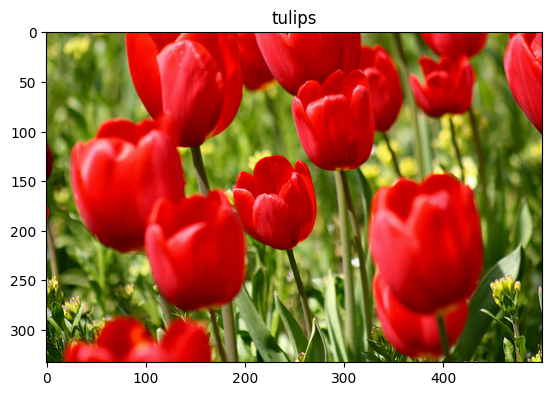

In [30]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

#### Definindo o tamanho das imagens e do mini-lote.

In [31]:
IMG_SIZE = 180

batch_size = 32

## Modificando o tamanho das imagens e aplicando escalonamento.

### Definindo uma função para redimensionar e escalonar as imagens.

In [32]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

### Aplicando o redimensionamento e escalonamento às imagens.

In [33]:
train_ds = (
    train_ds
    .map(resize_and_rescale, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [34]:
print(train_ds)
print(len(train_ds))

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
92


In [35]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [36]:
print(test_ds)
print(len(test_ds))

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
23


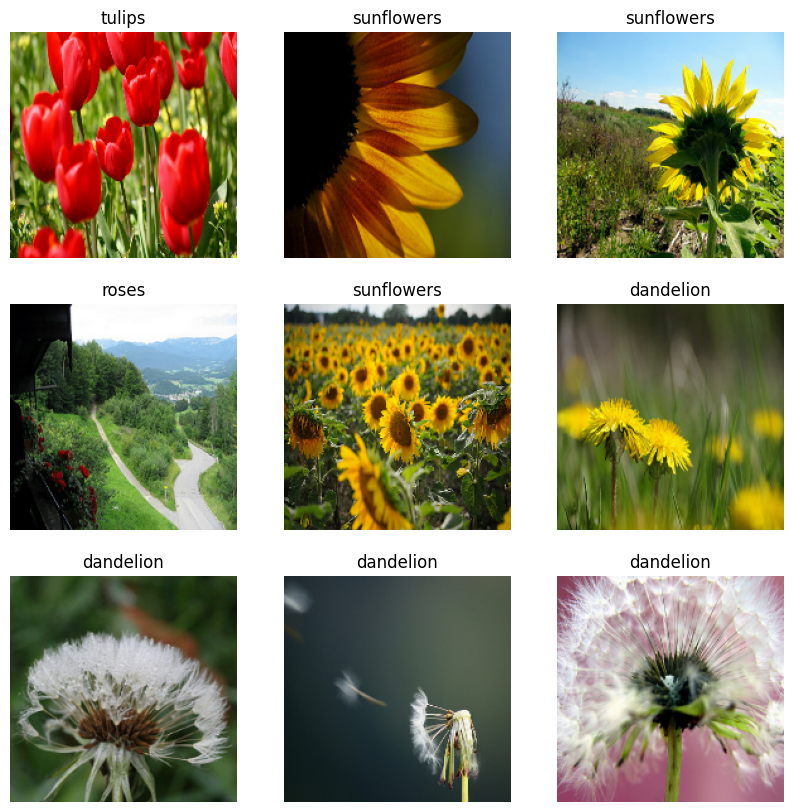

In [37]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Definindo, configurando e compilando o modelo de rede convolucional.

In [38]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [39]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [40]:
# Number of epochs.
epochs = 10

# Train the CNN.
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 9s 76ms/step - loss: 1.3560 - accuracy: 0.4234 - val_loss: 1.1187 - val_accuracy: 0.5232
Epoch 2/10
92/92 [==============================] - 2s 22ms/step - loss: 1.0409 - accuracy: 0.5821 - val_loss: 1.0013 - val_accuracy: 0.6035
Epoch 3/10
92/92 [==============================] - 2s 21ms/step - loss: 0.8734 - accuracy: 0.6764 - val_loss: 0.9367 - val_accuracy: 0.6444
Epoch 4/10
92/92 [==============================] - 3s 29ms/step - loss: 0.6918 - accuracy: 0.7524 - val_loss: 0.9889 - val_accuracy: 0.6240
Epoch 5/10
92/92 [==============================] - 2s 22ms/step - loss: 0.5133 - accuracy: 0.8304 - val_loss: 1.1018 - val_accuracy: 0.6213
Epoch 6/10
92/92 [==============================] - 2s 21ms/step - loss: 0.3826 - accuracy: 0.8760 - val_loss: 1.3413 - val_accuracy: 0.5899
Epoch 7/10
92/92 [==============================] - 2s 21ms/step - loss: 0.3232 - accuracy: 0.8883 - val_loss: 1.2661 - val_accuracy: 0.6213
Epoch 8/10
92

### Analisando os resultados do treinamento.

Os gráficos mostram que as acurácias de treinamento e de validação estão bem distantes. Além disso, a perda de validação está aumentando ao longo das épocas.

Claramente o modelo está se sobreajustando aos dados de treinamento.

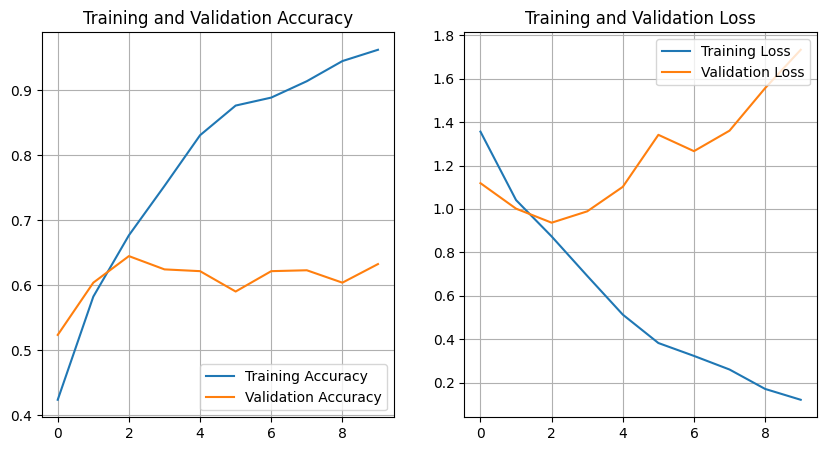

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid()

plt.show()

# Aplicando data augmentation à base de treinamento.


O overfitting geralmente ocorre quando há um pequeno número de exemplos de treinamento. O aumento de dados adota a abordagem de gerar dados de treinamento adicionais a partir de seus exemplos existentes, aumentando-os usando transformações aleatórias que produzem imagens. Isso ajuda a expor o modelo a mais variedades dos dados e a generalizar melhor.

Implementaremos o aumento de dados usando as seguintes camadas de pré-processamento do módulo Keras: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation` e `tf.keras.layers.RandomZoom`. Elas podem ser incluídos em um modelo como outras camadas e executadas na GPU.

## Baixando a base de dados novamente.

In [42]:
# Load the dataset.
(train_ds, test_ds), metadata = tfds.load(
    'tf_flowers',                                           # nome do dataset a ser baixado.
    split=['train[:80%]', 'train[80%:]'],                   # divisão do dataset.
    with_info=True,                                         # retorna o metadata do datase.
    as_supervised=True,                                     # retorna os rótulos.
)

### Redimensionando e escalonando os dados.

In [43]:
train_ds = (
    train_ds
    .map(resize_and_rescale, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [44]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

## Criando uma sequência de camadas para aplicar o data augmentation às imagens.

In [45]:
data_augmentation = tf.keras.Sequential(
    [
      tf.keras.layers.RandomFlip("horizontal_and_vertical", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
      tf.keras.layers.RandomRotation(0.25),
      tf.keras.layers.RandomZoom(0.1),
    ]
)

Visualizando alguns exemplos aumentados aplicando o aumento de dados à mesma imagem várias vezes:

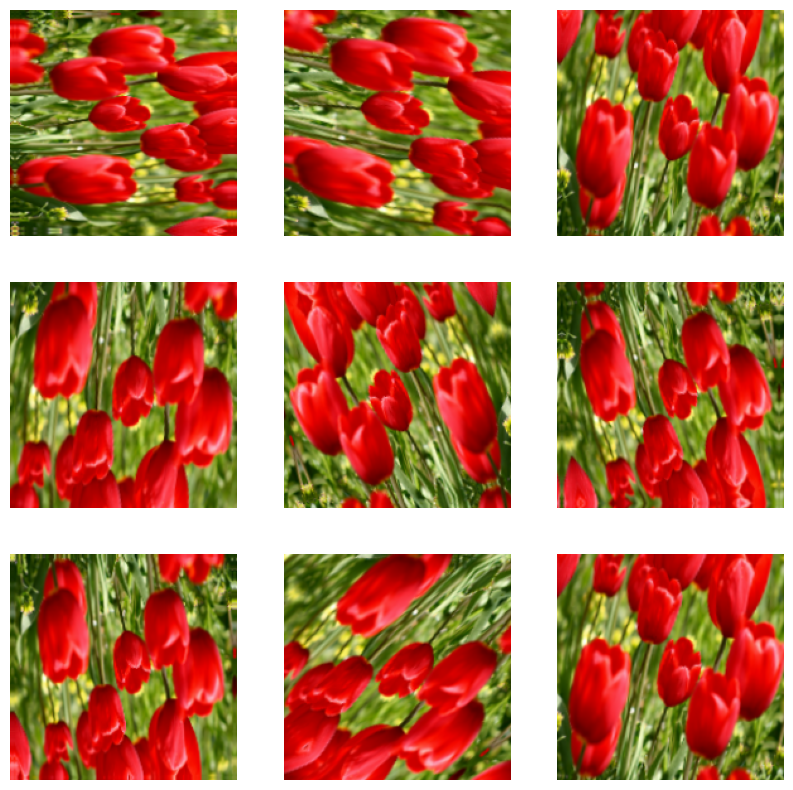

In [46]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy())
    plt.axis("off")

## Definindo, configurando e compilando o modelo de rede convolucional.

In [47]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, name="outputs")
])

In [48]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [49]:
# Number of epochs.
epochs = 15

# Train the CNN.
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 10s 80ms/step - loss: 1.2990 - accuracy: 0.4418 - val_loss: 1.0942 - val_accuracy: 0.5817
Epoch 2/15
92/92 [==============================] - 2s 25ms/step - loss: 1.0348 - accuracy: 0.5865 - val_loss: 0.9815 - val_accuracy: 0.6226
Epoch 3/15
92/92 [==============================] - 2s 24ms/step - loss: 0.9472 - accuracy: 0.6332 - val_loss: 0.9624 - val_accuracy: 0.6349
Epoch 4/15
92/92 [==============================] - 2s 24ms/step - loss: 0.8949 - accuracy: 0.6454 - val_loss: 0.9056 - val_accuracy: 0.6512
Epoch 5/15
92/92 [==============================] - 3s 32ms/step - loss: 0.8632 - accuracy: 0.6689 - val_loss: 0.9028 - val_accuracy: 0.6431
Epoch 6/15
92/92 [==============================] - 2s 24ms/step - loss: 0.8404 - accuracy: 0.6737 - val_loss: 0.8672 - val_accuracy: 0.6512
Epoch 7/15
92/92 [==============================] - 2s 24ms/step - loss: 0.7980 - accuracy: 0.7050 - val_loss: 0.8463 - val_accuracy: 0.6540
Epoch 8/15
9

### Analisando os resultados.

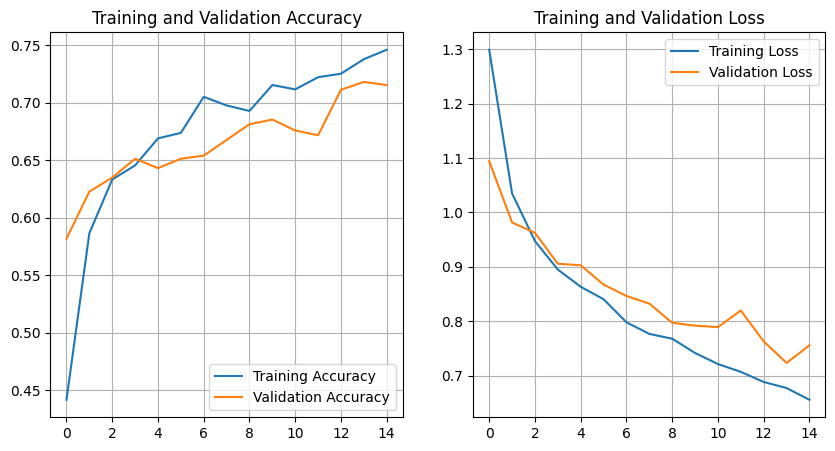

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid()

plt.show()

## Usando uma camada de *dropout*

Podemos reduzir um pouco mais o efeito do sobreajuste adicionando uma camada de *dropout* à rede neural.

Quando aplicamos o *dropout* a uma camada, ele elimina aleatoriamente (definindo a ativação como zero) um número de unidades de saída da camada durante o processo de treinamento. O dropout assume um número fracionário como valor de entrada, na forma de 0,1, 0,2, 0,4, etc. Isso significa eliminar 10%, 20% ou 40% das unidades de saída aleatoriamente da camada aplicada.

In [51]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, name="outputs")
])

In [52]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [53]:
# Number of epochs.
epochs = 15

# Train the CNN.
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 5s 32ms/step - loss: 1.3152 - accuracy: 0.4254 - val_loss: 1.2491 - val_accuracy: 0.5054
Epoch 2/15
92/92 [==============================] - 3s 30ms/step - loss: 1.0919 - accuracy: 0.5606 - val_loss: 1.0457 - val_accuracy: 0.5722
Epoch 3/15
92/92 [==============================] - 4s 43ms/step - loss: 0.9996 - accuracy: 0.6029 - val_loss: 0.9892 - val_accuracy: 0.6117
Epoch 4/15
92/92 [==============================] - 3s 32ms/step - loss: 0.9326 - accuracy: 0.6373 - val_loss: 0.9257 - val_accuracy: 0.6349
Epoch 5/15
92/92 [==============================] - 3s 30ms/step - loss: 0.8803 - accuracy: 0.6563 - val_loss: 0.9203 - val_accuracy: 0.6335
Epoch 6/15
92/92 [==============================] - 3s 34ms/step - loss: 0.8359 - accuracy: 0.6785 - val_loss: 0.8715 - val_accuracy: 0.6689
Epoch 7/15
92/92 [==============================] - 3s 31ms/step - loss: 0.8206 - accuracy: 0.6822 - val_loss: 0.8640 - val_accuracy: 0.6621
Epoch 8/15
92

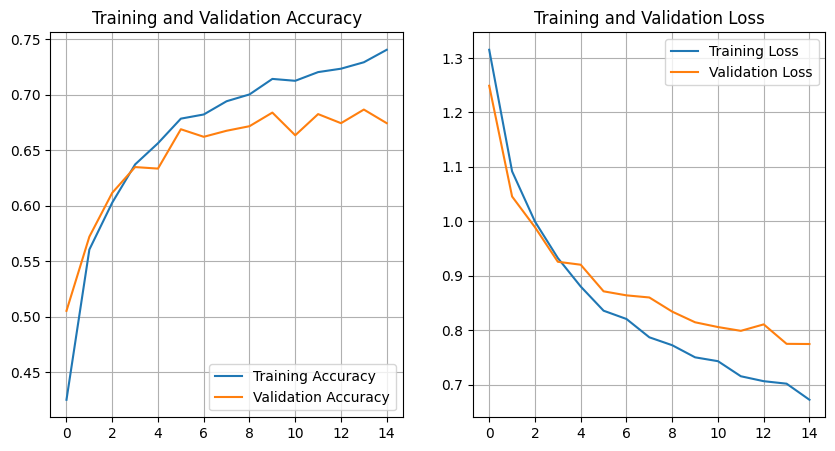

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid()

plt.show()